# Setting up

In [1]:
%%capture  
# Import notebook containing the imports the functions and the dataset
%run "./0. Imports and functions.ipynb"

# Overview and cleaning

In [2]:
# Loading dataset
df =  pd.read_csv('./data/clean_merged.csv')

### Rename US and UK

In [3]:
# Rename the Uk and US
df['socio1. In which country do you work?'].replace({'United Kingdom of Great Britain and Northern Ireland': "United Kingdom",
            'United States of America': 'United States'}, inplace=True)

# Drop Canada
df = df[df['socio1. In which country do you work?'] != 'Canada']

### Create a category world

As said, we are concerned about some countries specifically. However, we collect information about other countries as well. To avoid any confusion and having too much countries to plot, we group all of them into one category "world"

In [4]:
# Create a list of all countries of interest
list_countries = ['United Kingdom', 'Australia', 'United States', 'Germany', 'New Zealand', 'Netherlands', 'South Africa']

# Create a new columns if "World" if the country is not in the list
df['Country'] = df['socio1. In which country do you work?'].apply(lambda x: x if x in list_countries else 'World')

## Total of participants and removing non programmer

This is the total of participants. Here the participants are the people that have passed at least the first page.

In [5]:
len(df[df['Year']== 2018])

972

### Count of participants per country

We can see the distribution of participants among the countries as follow:

In [6]:


# Output the count per countries
df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame()

,socio1. In which country do you work?
Germany,331
United Kingdom,235
United States,147
Australia,98
Netherlands,48
New Zealand,37
South Africa,23
Czech Republic,6
Norway,6
France,5


### Visual representation of countries repartition

In [7]:
df_countries = df[df['Year']== 2018]['socio1. In which country do you work?'].value_counts().to_frame().reset_index()
df_countries.columns = ['name', 'count'] 

In [8]:
df_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Merge datasets together and replace nan with 0
df_map = df_map.merge(df_countries, on='name', how='outer')
df_map.fillna(0, inplace=True)
#df_map.plot()

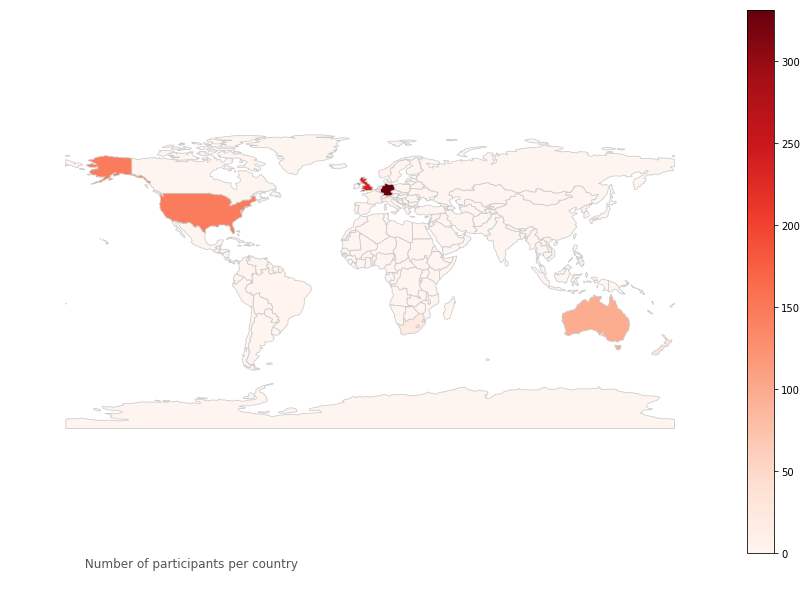

In [9]:
fig, ax = plt.subplots(1)
ax = df_map.plot(ax=ax, column='count', cmap='Reds', linewidth=0.8, edgecolor='0.8', legend=True)

# Add the description
description = """ Number of participants per country"""
plot = ax.annotate(description, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Remove axis
plot = ax.axis('off')

plt.show();

## Date of participation

In [10]:
def convert_time(x):
    """"""
    try:
        return datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S').strftime("%m-%d")
    except ValueError:
        return x

df['Date'] = df['submitdate. Date submitted'].apply(lambda x: convert_time(x))
df_submission_per_country = df[['Country', 'Date']].dropna()
total_per_country = df_submission_per_country.groupby(['Country'])['Date'].value_counts().to_frame()
total_per_country.columns = ['Count']
total_per_country = total_per_country.reset_index().sort_values(['Date', 'Country'], ascending=True)

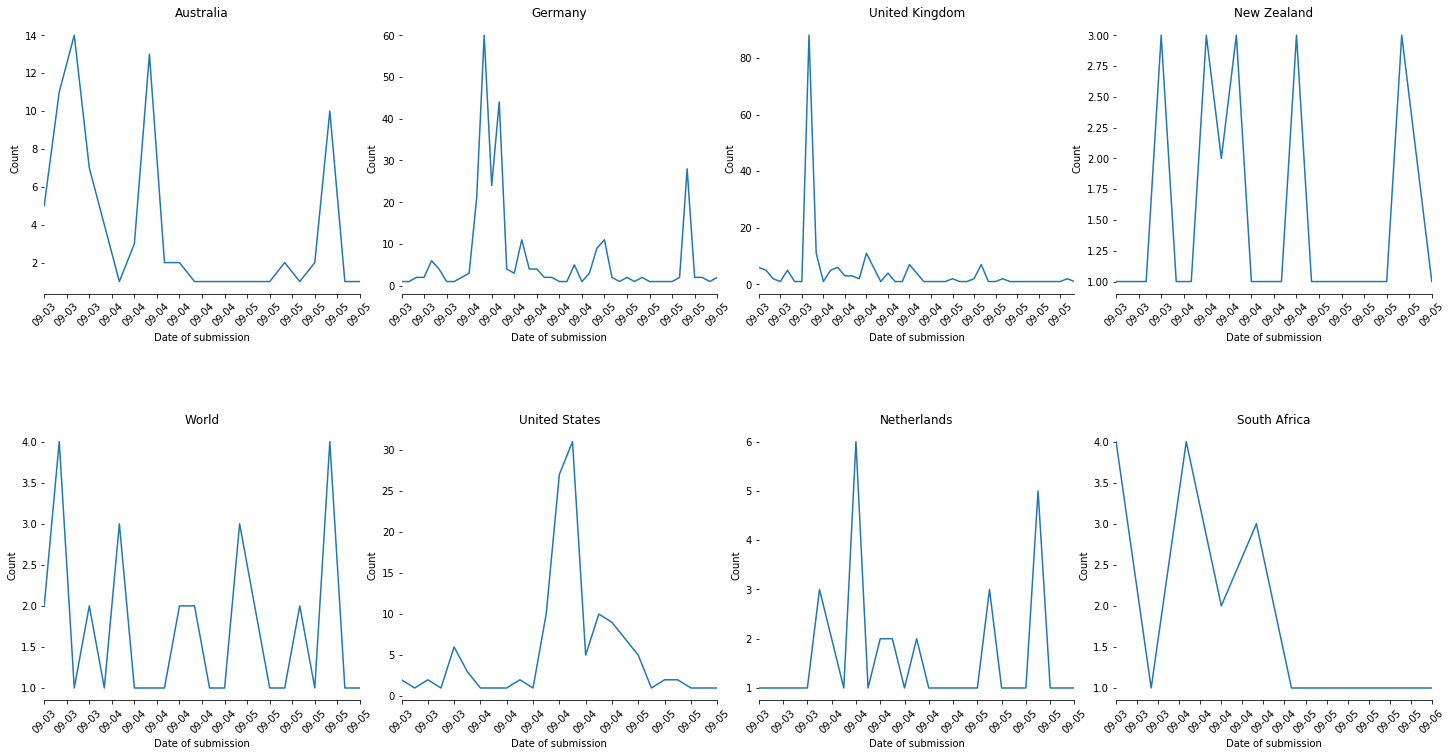

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
list_plots = list()
for i, name in enumerate(total_per_country['Country'].unique()):
    if i < 4:
        a = 0
        b = i
    else:
        a = 1
        b = 5 - i    
    axes[a, b] = total_per_country[total_per_country.Country == name].plot(x='Date', y='Count', legend=False, x_compat=True, ax=axes[a, b])#.set_ylabel(name)
    axes[a, b].set_title('{}'.format(name))
    axes[a, b].set_xticklabels(labels = total_per_country['Date'], rotation=45)
    axes[a, b].xaxis.set_major_locator(MaxNLocator(15))
    list_plots.append(axes[a, b])

for ax in list_plots:
    ax.set(xlabel="Date of submission", ylabel="Count")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.show();

## Repartition per countries.

We developed specific questions for the following countries:
* Australia
* Canada (but host their own version of the survey so they will not be analysed here)
* Germany
* Netherlands
* New Zealand
* South Africa
* United Kingdom
* United States

However, this year, we could also collect information about others countries. Each question that was specific to a country was also asked in the form of free text field for participants from other countries.


### Difference with the previous year

Several countries did the survey last year, here a summary of the difference in the amount of participants.

In [12]:
results = dict()
for country in df[df['Year']== 2017]['Country'].unique():
    current_year = df[df['Year']== 2018]['Country'].value_counts()[country]
    previous_year = df[df['Year']== 2017]['Country'].value_counts()[country]
    results[country] = {'2017': previous_year, '2018': current_year}
diff_year_participants = pd.DataFrame.from_dict(results, orient='index')
diff_year_participants['Difference between 2017 and 2018'] = diff_year_participants['2018'] - diff_year_participants['2017']

# Displaying the results
diff_year_participants

,2017,2018,Difference between 2017 and 2018
Germany,325,331,6
Netherlands,77,48,-29
South Africa,22,23,1
United Kingdom,253,235,-18
United States,164,147,-17


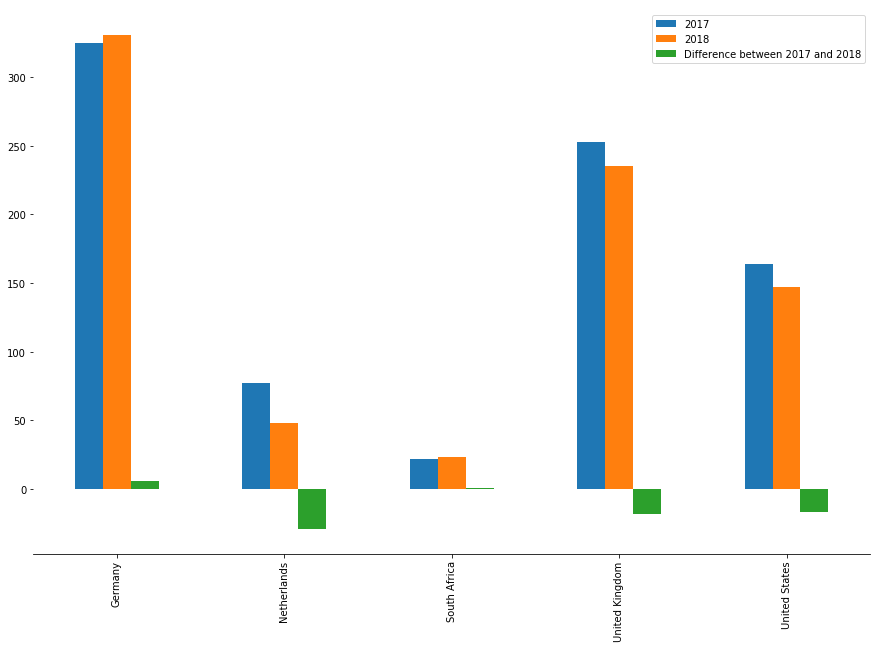

In [13]:
# Plotting the difference
ax = diff_year_participants.plot(kind='bar')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 

plt.show();

## Selecting valid participants only

However, on this total of participants, we only want the participants that code software during their work. 
We had a specific question for this purpose. We asked the participants if they are writing software or if they are leading a group of software developers. Each of these questions had the possibility of Yes/No answer. Here the exact wording of the questions:

* Do you write software for academic research as part of your job
* Does the majority of your role comprise leading a group of software developers or RSEs?

We will only select the participants who answered `Yes` to at least one question.

In [14]:
# Get the count of Y/N for the software developers
soft_dev = df['rse1. Do you write software for academic research as part of your job'].value_counts().to_frame()

# Get the count of Y/N for the leader developers
soft_lead = df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?'].value_counts().to_frame()

# Get the count for Y/N to any of the question
df['any_rse'] = np.where((df['rse1. Do you write software for academic research as part of your job'] == 'Yes') | (df['rse4de. Does the majority of your role comprise leading a group of software developers or RSEs?']), 'Yes', 'No')
soft_any = df['any_rse'].value_counts().to_frame()

# Create one df
result = pd.concat([soft_dev, soft_lead, soft_any], axis=1)#, sort=False)

# Rename columns
result.columns = ['Write software', 'Lead a team of software developers', 'At least one of the two']
result

,Write software,Lead a team of software developers,At least one of the two
No,67,929,14
Yes,1746,337,1799


This table is for both 2017 and 2018 year. For any further analysis, we remove the participants that answered 'No' at both of the question to only keep the ones that have work involving software development for both year to ensure a proper comparison. 

In [15]:
# Filtering the df
df = df[df['any_rse'] == 'Yes']
# drop the column `any_rse` as no use anymore
df.drop(['any_rse'], axis=1, inplace=True)

This brings the number of participants analysed to:

In [16]:
results = pd.DataFrame.from_dict([{'Participants in 2017': len(df[df['Year'] == 2017]), 
 'Participants in 2018': len(df[df['Year'] == 2018])}])
results

,Participants in 2017,Participants in 2018
0,828,971
